In [4]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [3]:
operation_count = 0

def generate_random_matrix(size):
    np.random.seed = 0
    return np.random.uniform(1e-8, 1.0, (size, size))

def add_matrix(A, B):
    global operation_count
    operation_count += A.shape[0] * B.shape[0]
    return A + B

def sub_matrix(A, B):
    global operation_count
    operation_count += A.shape[0] * B.shape[0]
    return A - B

def pad_to_power_of_two(matrix):
    rows, cols = matrix.shape
    new_size = 1 << max(rows, cols).bit_length()

    padded_matrix = np.zeros((new_size, new_size))

    padded_matrix[:rows, :cols] = matrix

    return padded_matrix

def mul(A, B):
    A_padded = pad_to_power_of_two(A)
    B_padded = np.zeros_like(A_padded)
    if len(B.shape) == 1:
        B_padded[:B.shape[0]] = B
        return strassen_recursive(A_padded, B_padded)[:B.shape[0]]
    
    B_padded[:B.shape[0], :B.shape[1]] = B
    return strassen_recursive(A_padded, B_padded)[:A.shape[0], :B.shape[1]]
    

def strassen_recursive(A, B):
    global operation_count

    n = A.shape[0]
    if n == 1:
        operation_count += 1
        return A * B
    elif A[0 ,0] == 0:
        return np.zeros_like(A)
    
    mid = n // 2

    A11 = A[:mid, :mid]
    A12 = A[:mid, mid:]
    A21 = A[mid:, :mid]
    A22 = A[mid:, mid:]

    B11 = B[:mid, :mid]
    B12 = B[:mid, mid:]
    B21 = B[mid:, :mid]
    B22 = B[mid:, mid:]

    P1 = strassen_recursive(add_matrix(A11, A22), add_matrix(B11, B22))
    P2 = strassen_recursive(add_matrix(A21, A22), B11)
    P3 = strassen_recursive(A11, sub_matrix(B12, B22))
    P4 = strassen_recursive(A22, sub_matrix(B21, B11))
    P5 = strassen_recursive(add_matrix(A11, A12), B22)
    P6 = strassen_recursive(sub_matrix(A21, A11), add_matrix(B11, B12))
    P7 = strassen_recursive(sub_matrix(A12, A22), add_matrix(B21, B22))

    C11 = add_matrix(sub_matrix(add_matrix(P1, P4), P5), P7)
    C12 = add_matrix(P3, P5)
    C21 = add_matrix(P2, P4)
    C22 = add_matrix(sub_matrix(add_matrix(P1, P3), P2), P6)

    C = np.vstack((np.hstack((C11, C12)), np.hstack((C21, C22))))

    return C

## Rekurencyjne odwracanie macierzy

In [6]:
def recursive_matrix_inverse(A):
    n = A.shape[0]

    if n == 1:
        return np.array([[1 / A[0, 0]]])
    
    mid = n // 2
    A11 = A[:mid, :mid]
    A12 = A[:mid, mid:]
    A21 = A[mid:, :mid]
    A22 = A[mid:, mid:]

    A11_inv = recursive_matrix_inverse(A11)

    S = A22 - mul(mul(A21, A11_inv), A12)

    S_inv = recursive_matrix_inverse(S)
    B11 = A11_inv + mul(mul(mul(mul(A11_inv, A12), S_inv), A21), A11_inv)
    B12 = mul(mul(-A11_inv, A12), S_inv)
    B21 = mul(mul(-S_inv, A21), A11_inv)
    B22 = S_inv

    A_inverse = np.vstack((
        np.hstack((B11, B12)),
        np.hstack((B21, B22))
        ))

    return A_inverse

In [124]:
start = 1
stop = 30

for test_num in range(start, stop+1):
    matrix = generate_random_matrix(test_num)

    while np.linalg.det(matrix) == 0:
        matrix = generate_random_matrix(test_num)
    
    matrix_inv_recursive = recursive_matrix_inverse(matrix)
    matrix_inv_numpy = np.linalg.inv(matrix)

    if np.allclose(matrix_inv_recursive, matrix_inv_numpy):
        # print(f"Test passed for random matrix of size {test_num}x{test_num}")
        continue
    else:
        print(f"Test failed for random matrix of size {test_num}x{test_num}")
        print("Solution using recursive inverse:")
        print(matrix_inv_recursive)

        print("Expected solution:")
        print(matrix_inv_numpy)
        break
else:
    print(f"Test passed for random square matrices of sizes {start}x{start} to {stop}x{stop}")

Test passed for random square matrices of sizes 1x1 to 30x30


## Rekurencyjna LU faktoryzacja 

In [109]:
def lu_recursive(A):
    n = A.shape[0]

    if n == 1:
        return np.array([[1]]), np.array([[A[0,0]]])
    
    mid = (n + 1) // 2
    A11 = A[:mid, :mid]
    A12 = A[:mid, mid:]
    A21 = A[mid:, :mid]
    A22 = A[mid:, mid:]

    L11, U11 = lu_recursive(A11)
    U11_inv = recursive_matrix_inverse(U11)
    L11_inv = recursive_matrix_inverse(L11)

    L21 = mul(A21, U11_inv)
    U12 = mul(L11_inv, A12)

    S = A22 - mul(L21, U12)
    Ls, Us = lu_recursive(S)

    L = np.block([
        [L11, np.zeros((mid, A.shape[1] - mid))],
        [L21, Ls]
    ])

    U = np.block([
        [U11, U12],
        [np.zeros((A.shape[0] - mid, mid)), Us]
    ])

    return L, U

In [128]:
start = 1
stop = 40

for test_num in range(start, stop+1):
    matrix = generate_random_matrix(test_num)
    
    L, U = lu_recursive(matrix)
    matrix_reconstructed = L @ U

    if np.allclose(matrix, matrix_reconstructed):
        # print(f"Test passed for random matrix of size {test_num}x{test_num}")
        continue

    else:
        print(f"Test failed for random matrix of size {test_num}x{test_num}")
        print("Solution using lu recursive:")
        print(matrix_inv_recursive)

        print("Expected solution:")
        print(matrix_inv_numpy)
        break
else:
    print(f"Test passed for random square matrices of sizes {start}x{start} to {stop}x{stop}")

Test passed for random square matrices of sizes 1x1 to 40x40


## Rekurencyjne obliczanie wyznacznika macierzy

In [115]:
def recursive_determinant_lu(A):
    L, U = lu_recursive(A)
    return np.prod(np.diag(L)) * np.prod(np.diag(U))

In [129]:
start = 1
stop = 50

for test_num in range(start, stop+1):
    A = generate_random_matrix(test_num)

    A_det_recursive = recursive_determinant_lu(A)
    A_det_numpy = np.linalg.det(A)    
    
    if np.allclose(A_det_recursive, A_det_numpy):
        # print(f"Test passed for random A of size {test_num}x{test_num}")
        continue
    else:
        print(f"Test failed for random square matrices of size {test_num}x{test_num}")
        print("Solution using recursive determinant:")
        print(A_det_recursive)

        print("Expected solution:")
        print(A_det_numpy)
        break
else:
    print(f"Test passed for random square matrices of sizes {start}x{start} to {stop}x{stop}")

Test passed for random square matrices of sizes 1x1 to 50x50


## Rekurencyjna eliminacja Gaussa

In [119]:
def recursive_gaussian_elimination(A, b):
    n = A.shape[0]

    if n == 1:
        return np.array([b[0] / A[0, 0]])
    
    mid = n // 2
    A11 = A[:mid, :mid]
    A12 = A[:mid, mid:]
    A21 = A[mid:, :mid]
    A22 = A[mid:, mid:]

    b1 = b[:mid]
    b2 = b[mid:]

    L11, U11 = lu_recursive(A11)

    L11_inv = recursive_matrix_inverse(L11)
    U11_inv = recursive_matrix_inverse(U11)

    S = A22 - mul(mul(mul(A21, U11_inv), L11_inv), A12)

    Ls, Us = lu_recursive(S)
    Ls_inv = recursive_matrix_inverse(Ls)
    Us_inv = recursive_matrix_inverse(Us)

    RHS1 = L11_inv @ b1
    RHS2 = Ls_inv @ b2 - Ls_inv @ A21 @ U11_inv @ RHS1

    x2 = Us_inv @ RHS2
    x1 = U11_inv @ RHS1 - U11_inv @ L11_inv @ A12 @ x2
    
    x = np.concatenate((x1, x2))

    return x

In [147]:
start = 1
stop = 50

for test_num in range(start, stop+1):
    A = generate_random_matrix(test_num)
    b = np.random.rand(test_num)

    while np.linalg.det(A) == 0:
        A = generate_random_matrix(test_num)

    x_recursive = recursive_gaussian_elimination(A, b)
    x_numpy = np.linalg.solve(A, b)
    
    if np.allclose(x_recursive, x_numpy):
        # print(f"Test passed for random A of size {test_num}x{test_num}")
        continue
    else:
        print(f"Test failed for random square matrices of size {test_num}x{test_num}")
        print("Solution using recursive Gaussian elimination:")
        print(x_recursive)

        print("Expected solution:")
        print(x_numpy)
        break
else:
    print(f"Test passed for random square matrices of sizes {start}x{start} to {stop}x{stop}")

Test passed for random square matrices of sizes 1x1 to 50x50


## Testy wydajnościowe zaimplementowanych funkcji rekurencyjnych

In [21]:
def draw_times(times, title):
    xs = [i for i in range(1, 201)]
    plt.figure(figsize=(10,8))
    plt.plot(xs, times, color="blue", marker='o')
    plt.title(title)
    plt.xlabel('Matrix size')
    plt.ylabel('time')
    plt.show()

In [152]:
def draw_all(xs, ylabel, inv_times, lu_times, det_times, elimination_times, save_as):
    # xs = [i for i in range(1, 301)]
    fig, axs = plt.subplots(2, 2, figsize=(16,10))
    axs[0, 0].plot(xs, inv_times, color='blue', marker='o')
    axs[0, 0].set_title('Rekurencyjne odwracanie macierzy')

    axs[0, 1].plot(xs, lu_times, color='orange', marker='o')
    axs[0, 1].set_title('Rekurencyjna LU faktoryzacja')

    axs[1, 0].plot(xs, det_times, color='green', marker='o')
    axs[1, 0].set_title('Rekurencyjne obliczanie wyznacznika')

    axs[1, 1].plot(xs, elimination_times, color='red', marker='o')
    axs[1, 1].set_title('Rekurencyjna eliminacja Gaussa')

    for ax in axs.flat:
        ax.set(xlabel='Matrix size', ylabel=ylabel)

    fig.savefig(save_as)

    plt.show()

In [150]:
inv_times = []
det_times = []
lu_times = []
elimination_times = []

inv_flops = []
det_flops = []
lu_flops = []

xs = [i for i in range(1, 101, 10)]
for size in xs:
    print(f'Currently computing {size}x{size}')
    A = generate_random_matrix(size)

    operation_count = 0
    start = time()
    A_inv = recursive_matrix_inverse(A)
    inv_times.append(time() - start)
    inv_flops.append(operation_count)

    operation_count = 0
    start = time()
    L, U = lu_recursive(A)
    lu_times.append(time() - start)
    lu_flops.append(operation_count)

    operation_count = 0
    start = time()
    det = recursive_determinant_lu(A)
    det_times.append(time() - start)
    det_flops.append(operation_count)

    b = np.random.rand(size)
    start = time()
    x = recursive_gaussian_elimination(A, b)
    elimination_times.append(time() - start)

Currently computing 1x1
Currently computing 11x11
Currently computing 21x21
Currently computing 31x31
Currently computing 41x41
Currently computing 51x51
Currently computing 61x61
Currently computing 71x71
Currently computing 81x81
Currently computing 91x91


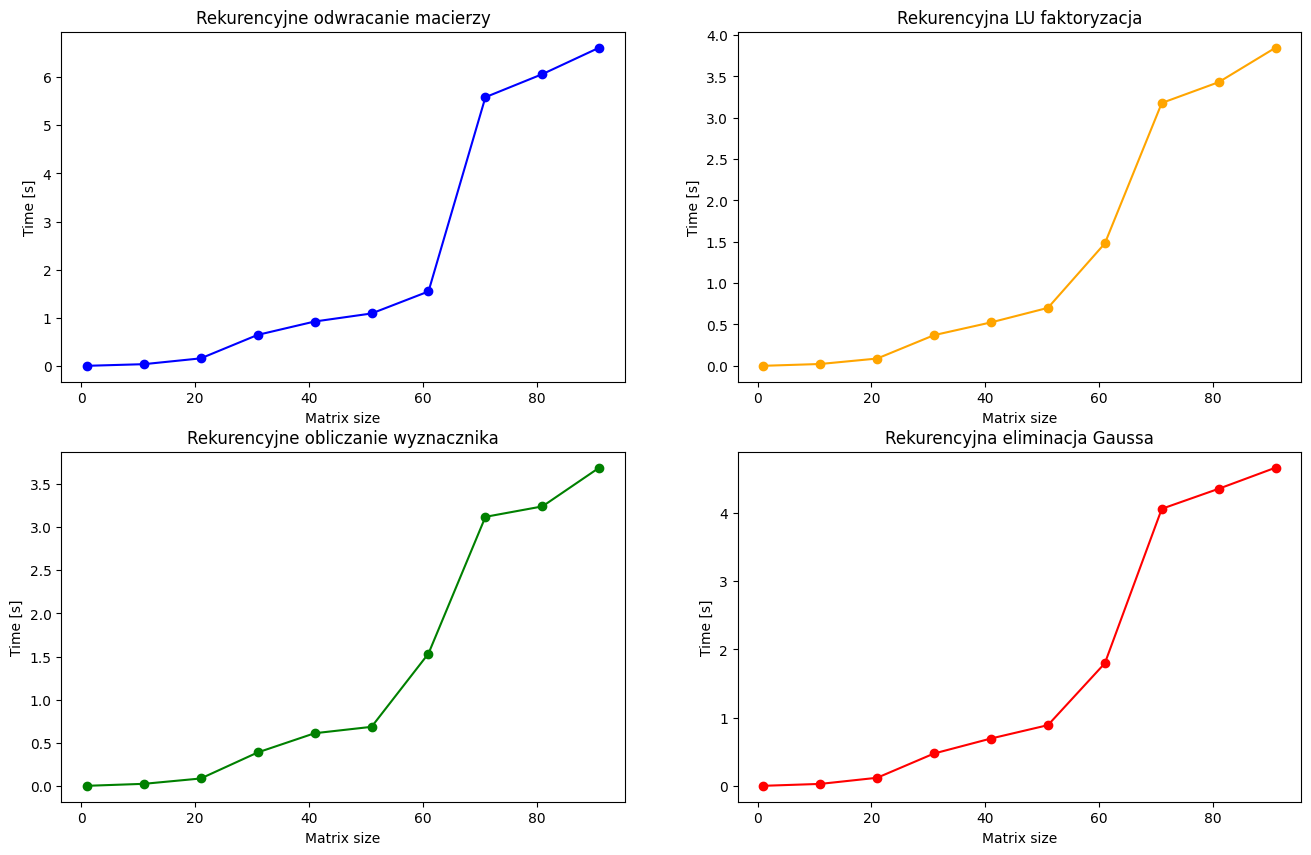

In [156]:
draw_all(xs, 'Time [s]', inv_times, lu_times, det_times, elimination_times, 'plot2.png')

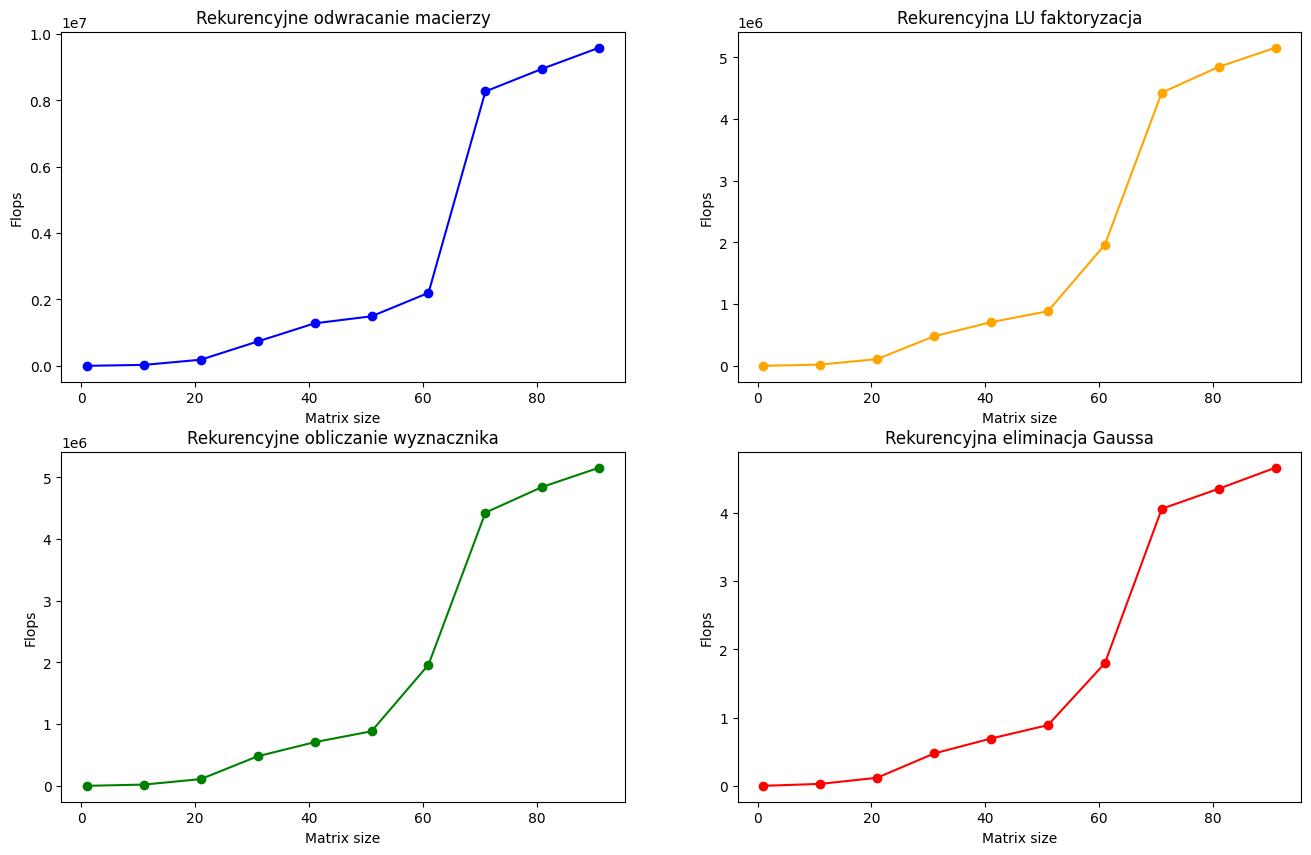

In [155]:
draw_all(xs, 'Flops', inv_flops, lu_flops, det_flops, elimination_times, 'plot3.png')

## Oszacowanie złożoności obliczeniowej

In [120]:
sizes = np.linspace(8, 100, 40, dtype=np.int32)
times = []

for n in sizes:
    A = generate_random_matrix(n)
    b = np.random.rand(n)
    start = time()
    x = recursive_gaussian_elimination(A, b)
    times.append(time() - start)
    print(f'Computed {n}x{n}')

Computed 8x8
Computed 10x10
Computed 12x12
Computed 15x15
Computed 17x17
Computed 19x19
Computed 22x22
Computed 24x24
Computed 26x26
Computed 29x29
Computed 31x31
Computed 33x33
Computed 36x36
Computed 38x38
Computed 41x41
Computed 43x43
Computed 45x45
Computed 48x48
Computed 50x50
Computed 52x52
Computed 55x55
Computed 57x57
Computed 59x59
Computed 62x62
Computed 64x64
Computed 66x66
Computed 69x69
Computed 71x71
Computed 74x74
Computed 76x76
Computed 78x78
Computed 81x81
Computed 83x83
Computed 85x85
Computed 88x88
Computed 90x90
Computed 92x92
Computed 95x95
Computed 97x97
Computed 100x100


0.00039217317977771794 2.03


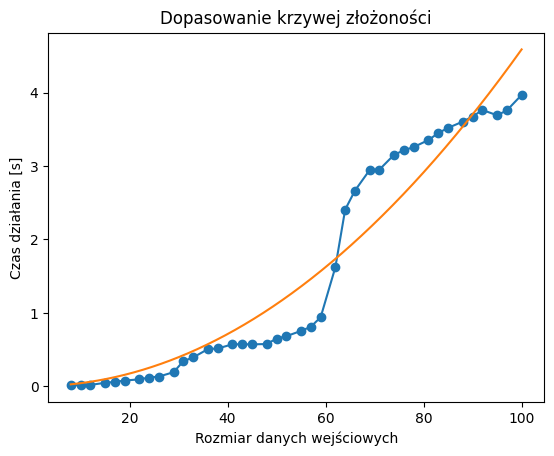

In [122]:
from scipy.optimize import curve_fit

def model(x, a, deg):
    return a * x ** deg


w = curve_fit(model, sizes, times)[0]
print(w[0], np.round(w[1], 2))

plt.scatter(sizes, times)
plt.plot(sizes, times)
x = np.linspace(8, 100, 1000)
plt.plot(x, model(x, w[0], w[1]))

plt.xlabel("Rozmiar danych wejściowych")
plt.ylabel("Czas działania [s]")
plt.title("Dopasowanie krzywej złożoności")
plt.show()